In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import h5py
import scipy.signal
import scipy.optimize


import psd

import logging

from lisainstrument import Instrument


from pytdi import Data
from pytdi import michelson as mich
from pytdi import ortho


In [3]:
orbit_path = '../orbits.h5'
gw_path = 'gws.h5'
measurement_path = 'measurements/filt_test.h5'

with h5py.File(orbit_path) as orbits:
    orbits_t0 = orbits.attrs['t0']


In [15]:
# Setup logger (sometimes useful to follow what's happening)
#logging.basicConfig()
#logging.getLogger('lisainstrument').setLevel(logging.INFO)

# Create your instrumental setup
instru = Instrument(
    size=10000, # in samples
    lock='six',
    orbits=orbit_path, # realistic orbits (make sure it's consistent with glitches and GWs!)
    gws=gw_path)

#instru.disable_all_noises(but='laser') # only laser noise
#instru.disable_all_noises()

In [16]:
!rm measurements/filt_test.h5

# Simulate and write measurements
instru.simulate()
instru.write(measurement_path)

In [2]:
#rec = ['X','Y','Z', 'A','E','T']
rec = ['X','Y','Z']

def hdf5_to_array(path, records=rec, discard=600):
    data = h5py.File(path)
    ret = np.array([np.array(data[k]).transpose() for k in records])
    return ret[:,:,discard:]

In [4]:
# Read data from LISA Instrument
my_data = Data.from_instrument(measurement_path)

In [5]:
print (my_data.args.keys())
print (my_data.measurements.keys())


dict_keys(['delays', 'fs', 'delay_derivatives'])
dict_keys(['isi_12', 'rfi_12', 'tmi_12', 'isi_sb_12', 'rfi_sb_12', 'isi_23', 'rfi_23', 'tmi_23', 'isi_sb_23', 'rfi_sb_23', 'isi_31', 'rfi_31', 'tmi_31', 'isi_sb_31', 'rfi_sb_31', 'isi_13', 'rfi_13', 'tmi_13', 'isi_sb_13', 'rfi_sb_13', 'isi_32', 'rfi_32', 'tmi_32', 'isi_sb_32', 'rfi_sb_32', 'isi_21', 'rfi_21', 'tmi_21', 'isi_sb_21', 'rfi_sb_21'])


In [7]:
discard = 300

X = mich.X2.build(**my_data.args)(my_data.measurements)[discard:]
Y = mich.Y2.build(**my_data.args)(my_data.measurements)[discard:]
Z = mich.Z2.build(**my_data.args)(my_data.measurements)[discard:]

#t = instru.t[discard:]
t = (np.arange(0,len(X)+discard)/4)[discard:]

dat = {'X':X,'Y':Y,'Z':Z}

In [8]:
A = ortho.A2.build(**my_data.args)(my_data.measurements)[discard:]
E = ortho.E2.build(**my_data.args)(my_data.measurements)[discard:]
T = ortho.T2.build(**my_data.args)(my_data.measurements)[discard:]

print (A,E,T)

[ 13.01263505 -20.82517774  28.33598883 ...  52.87847468 -50.20046107
  49.06404369] [-24.92193327  29.16221413 -30.45838564 ... -61.97691818  53.08856348
 -44.6741852 ] [-12.48035406  15.82183339 -18.36937456 ...  26.04682427 -27.45071516
  26.51099557]


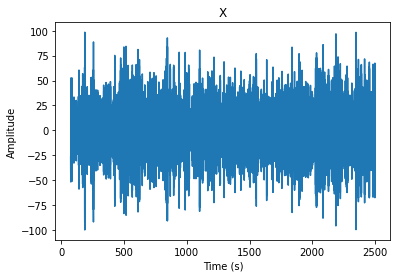

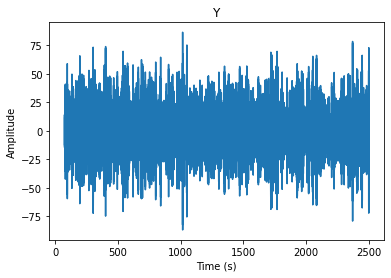

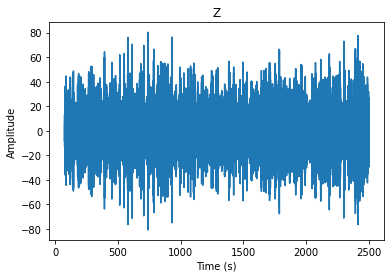

In [21]:
for i in rec:
    plt.plot(t,dat[i])
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(i)
    plt.show()

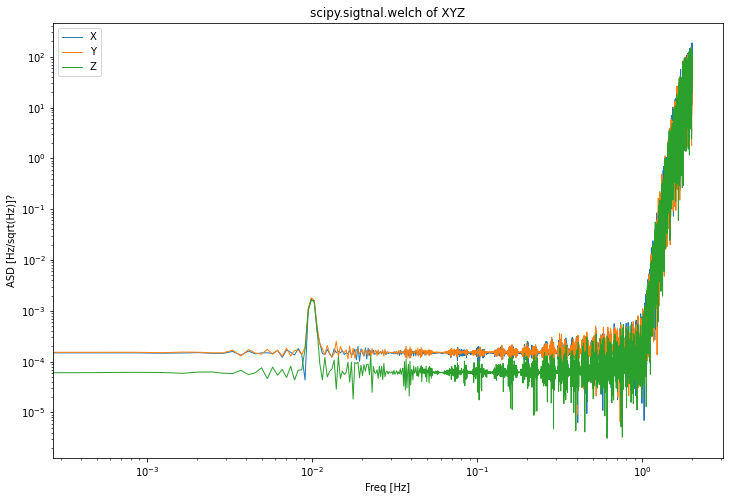

In [22]:
plt.figure(figsize=(12,8))
for i in rec:
    f, psd = scipy.signal.welch(dat[i], fs=instru.fs, window='nuttall',\
                        nperseg=len(dat[i]), detrend=False)
    plt.plot(f,np.sqrt(psd),label=i,linewidth=1)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Freq [Hz]')
plt.ylabel('ASD [Hz/sqrt(Hz)]?')
plt.title("scipy.sigtnal.welch of "+rec[0]+rec[1]+rec[2])
#plt.xlim(5e-4,2)
plt.legend()
plt.show()

In [23]:
filtdat = {}
coeffs1 = scipy.signal.firls(73,bands=[0,1,1.2,2],desired=[1,1,0,0],fs=4)
tightfiltdat = {}
coeffs2 = scipy.signal.firls(73,bands=[0,.5,.7,2],desired=[1,1,0,0],fs=4)

for i in rec:
    filtdat[i] = scipy.signal.filtfilt(coeffs1,1., x=dat[i],padlen=len(f))
    tightfiltdat[i] = scipy.signal.filtfilt(coeffs2,1.,x=dat[i],padlen=len(f))
    print (len(filtdat[i]))

9700
9700
9700


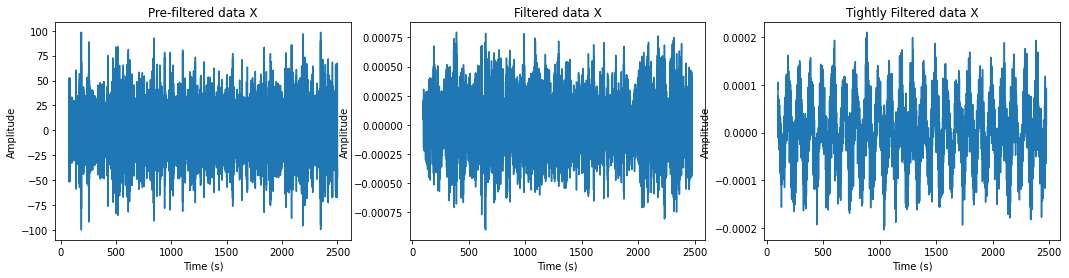

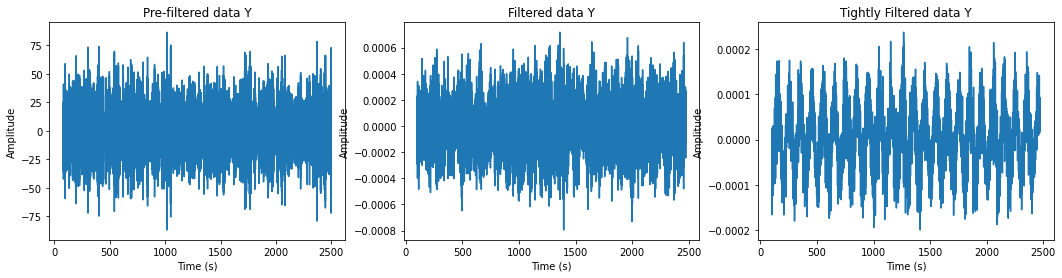

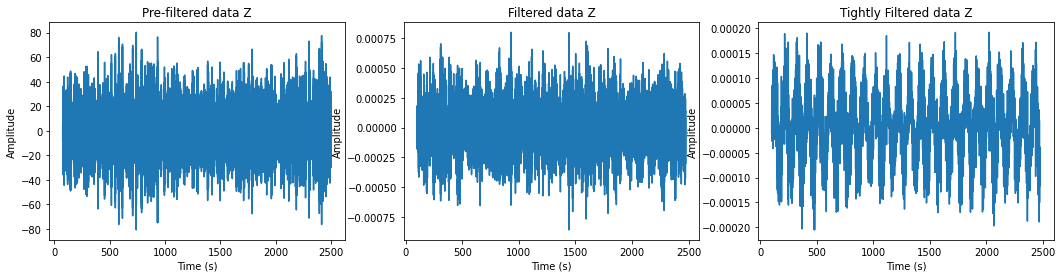

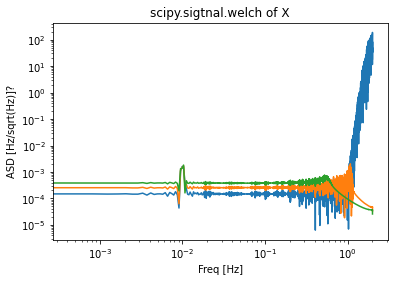

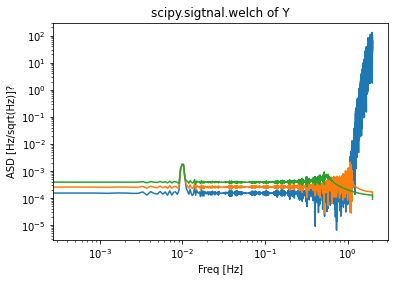

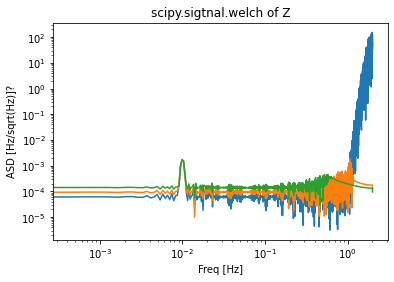

In [24]:
for i in rec:
    fig, axs = plt.subplots(1,3)
    fig.set_figheight(4)
    fig.set_figwidth(18)
    axs[0].plot(t,dat[i])
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Amplitude")
    axs[0].set_title("Pre-filtered data "+i)
    
    axs[1].plot(t[100:-100],filtdat[i][100:-100])
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("Amplitude")
    axs[1].set_title("Filtered data "+i)
    
    axs[2].plot(t[100:-100],tightfiltdat[i][100:-100])
    axs[2].set_xlabel("Time (s)")
    axs[2].set_ylabel("Amplitude")
    axs[2].set_title("Tightly Filtered data "+i)

for i in rec:
    f1, psd1 = scipy.signal.welch(dat[i], fs=4, window='nuttall', nperseg=len(dat[i]), detrend=False)
    f2, psd2 = scipy.signal.welch(filtdat[i], fs=4, window='nuttall', nperseg=len(dat[i]), detrend=False)
    f3, psd3 = scipy.signal.welch(tightfiltdat[i], fs=4, window='nuttall', nperseg=len(dat[i]), detrend=False)
    
    plt.figure(figsize=(6,4))
    plt.plot(f1,np.sqrt(psd1))
    plt.plot(f2,np.sqrt(psd2))
    plt.plot(f3,np.sqrt(psd3))
    plt.plot()
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Freq [Hz]')
    plt.ylabel('ASD [Hz/sqrt(Hz)]?')
    plt.title("scipy.sigtnal.welch of "+i)
    plt.show()


In [25]:
def sine(x,A,B,f,x0):
    return B*np.sin(2*np.pi*f*(x-x0))

/home/bart/Desktop/lisa/venv-lisa/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[ 0.00000000e+00 -1.18723821e-04  1.00587313e-02  1.05617923e+02]
[ 0.00000000e+00 -7.20609542e-05  9.99798640e-03 -8.60566776e+01]
[ 0.00000000e+00 -7.21240696e-05  9.99809883e-03 -8.60454591e+01]


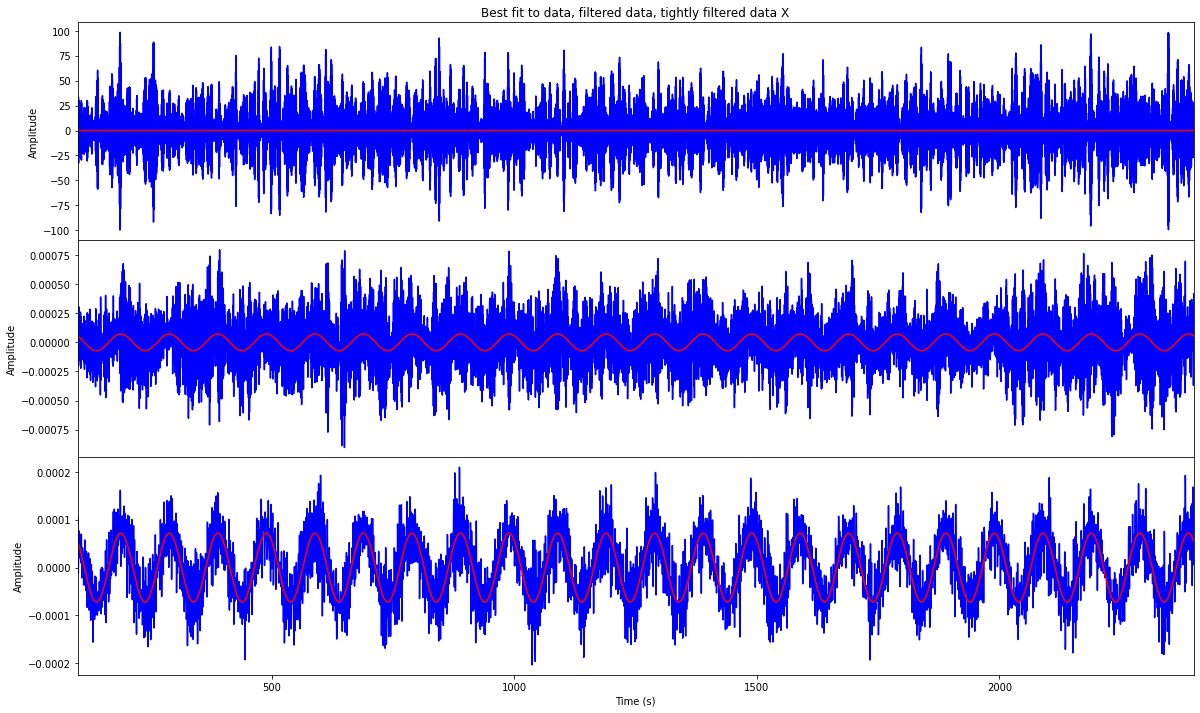

/home/bart/Desktop/lisa/venv-lisa/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[ 0.00000000e+00  3.32374812e-03  7.85813078e-03 -5.54004293e+02]
[ 0.00000000e+00 -7.74716999e-05  9.99521354e-03  1.79633516e+02]
[ 0.00000000e+00 -7.75613974e-05  9.99520428e-03  1.79627225e+02]


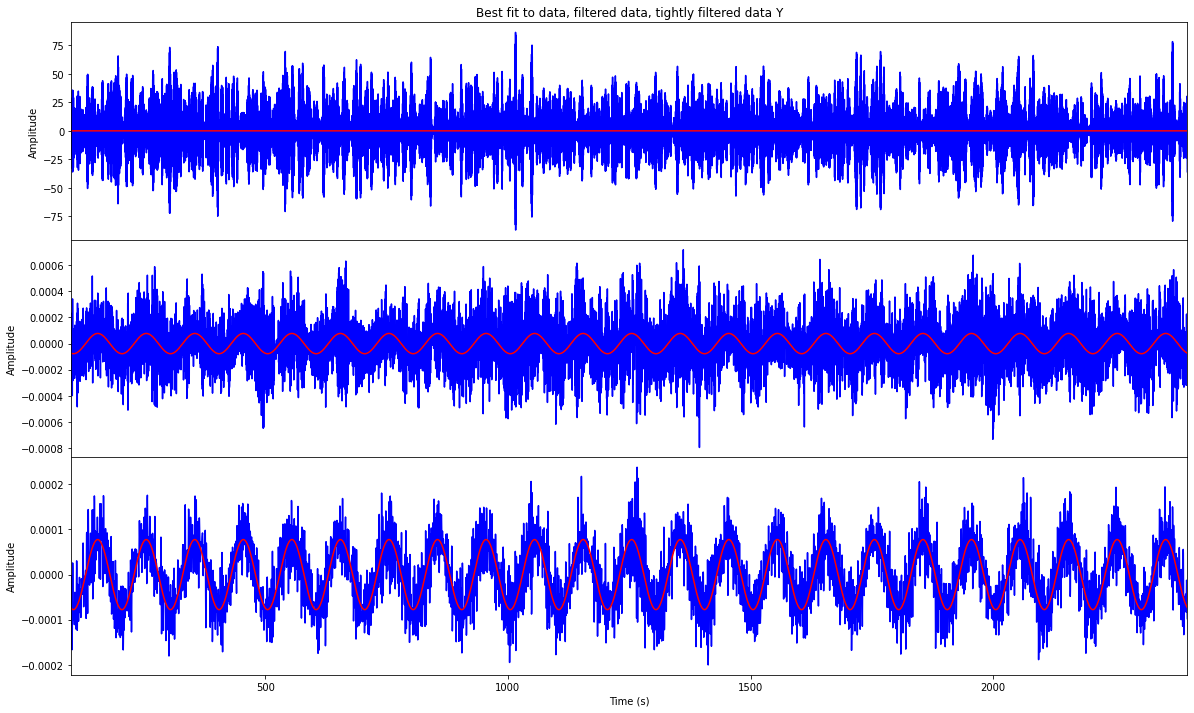

/home/bart/Desktop/lisa/venv-lisa/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[ 0.00000000e+00 -4.28709970e-05 -5.60574451e-03 -2.59988771e+03]
[ 0.00000000e+00  7.20867823e-05  9.99700797e-03 -4.18261408e+00]
[ 0.00000000e+00  7.21490315e-05  9.99709203e-03 -4.16637463e+00]


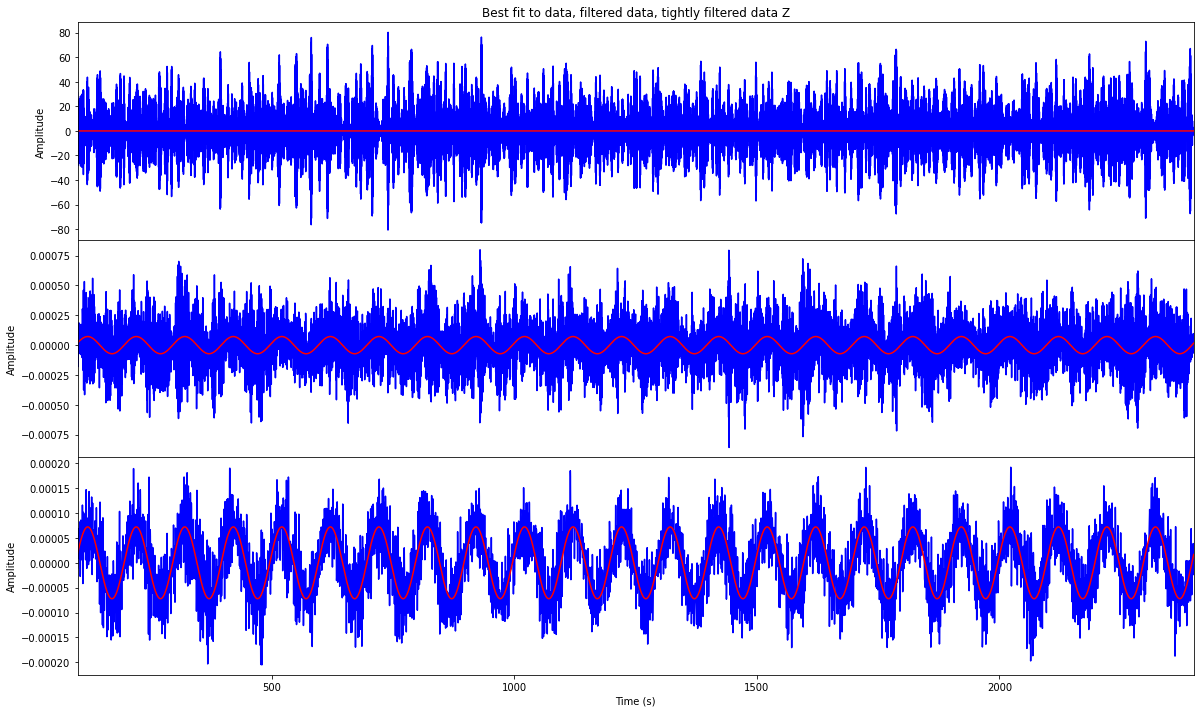

In [26]:
for i in rec:
    popt1, pcov1 = scipy.optimize.curve_fit(sine,t[100:-100],dat[i][100:-100],p0=(0,2e-4,1e-2,0))
    popt2, pcov2 = scipy.optimize.curve_fit(sine,t[100:-100],filtdat[i][100:-100],p0=(0,7e-6,1e-2,0))
    popt3, pcov3 = scipy.optimize.curve_fit(sine,t[100:-100],tightfiltdat[i][100:-100],p0=(0,7e-6,1e-2,0))
    popt = [popt1,popt2,popt3]
    print (popt1)
    print (popt2)
    print (popt3)
    
    fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
    fig.set_figheight(12)
    fig.set_figwidth(20)
    axs[0].plot(t[100:-100],dat[i][100:-100],c='b')
    axs[1].plot(t[100:-100],filtdat[i][100:-100],c='b')
    axs[2].plot(t[100:-100],tightfiltdat[i][100:-100],c='b')
    
    for j in range(3):
        axs[j].plot(t[100:-100], sine(t[100:-100],*popt[j]),c='r')
        axs[j].set_ylabel("Amplitude")
    axs[j].set_xlabel("Time (s)")
    axs[j].set_xlim(100,2400)
    axs[0].set_title("Best fit to data, filtered data, tightly filtered data "+i)
    plt.show()


In [ ]:
ty